# Create a FMU
at the example of the well-known *bouncing ball*

Tutorial by Tobias Thummerer, Simon Exner | Last edit: February 2025

🚧 This is still WIP and we add additional information and description, soon! 🚧

## License

In [1]:
#
# Copyright (c) 2021 Tobias Thummerer, Lars Mikelsons
# Licensed under the MIT license. See LICENSE file in the project root for details.
#

## Introduction

This Julia Package FMIExport.jl enables the export of simulation models from Julia code. The FMI (Functional Mock-up Interface) is a free standard ([fmi-standard.org](https://fmi-standard.org)) that defines a *model container* and an interface to exchange simulation models using a combination of XML files, binaries and C code zipped into a single file. The magic on the Julia side happens by compiling Julia code to a DLL (Windows) or LIB (Linux) by using the *PackageCompiler.jl*, therefore a *package* is defined to be compiled - instead of just a single file. This is very important to keep in mind.

## Getting started 
To allow for editing the example, you can make a copy of the examples folder. In case you just want to lean back and enjoy the magic, you can proceed by just *opening* the bouncing ball example. 

In the creation of the FMU, an entire package is involved. However, the things that need to be defined by you can happen within only a single file. In case of the bouncing ball, this file is [BouncingBall.jl](https://github.com/ThummeTo/FMIExport.jl/blob/main/examples/FMI2/BouncingBall/src/BouncingBall.jl). If we have a look inside, we find many interesting things, that we investigate in detail now. The code in the following only investigates *snippets*, for full running code see the [examples folder](https://github.com/ThummeTo/FMIExport.jl/blob/main/examples/).

We start by loading the library.

In [2]:
using FMIExport
using FMIExport.FMIBase.FMICore: fmi2True, fmi2False, fmi2Integer

Further, we define a start state and initial parameters.

In [3]:
# a minimum height to reset the ball after event
EPS = 1e-8

# ball position, velocity (initial)
DEFAULT_X0 = [1.0, 0.0]
# ball mass, ball radius, ball collision damping, ball minimum velocity, gravity constant 
DEFAULT_PARAMS = [1.0, 0.1, 0.9, 1e-3, 9.81]

5-element Vector{Float64}:
 1.0
 0.1
 0.9
 0.001
 9.81

### Initialization function
For solving IVPs (initial value problems), we require an *inital value* - for ODEs, this is the initial state. Therefore, we define a function, that computes (or just returns) a start state to start the algorithm for numerical integration to obtain a solution.

In [4]:
FMU_FCT_INIT = function()
   
    sticking = fmi2False
    counter = fmi2Integer(0)

    s = DEFAULT_X0[1]         # ball position
    v = DEFAULT_X0[2]         # ball velocity
    a = 0.0                   # ball acceleration

    t = 0.0        
    x_c = [s, v]      
    ẋ_c = [v, a]
    x_d = [sticking, counter]
    u = []
    p = DEFAULT_PARAMS

    return (t, x_c, ẋ_c, x_d, u, p)
end

#1 (generic function with 1 method)

### Function for the right-hand side
After we defined start values for the integration, we need to define what is actually integrated. For ODEs, this is refered to as the *right-hand side*, a function, that defines derivatives that are numerically integrated by the ODE solver.

In [5]:
FMU_FCT_EVALUATE = function(t, x_c, ẋ_c, x_d, u, p, eventMode)
    m, r, d, v_min, g = p
    s, v = x_c
    sticking, counter = x_d
    _, a = ẋ_c

    if sticking == fmi2True
        a = 0.0
    elseif sticking == fmi2False

        if eventMode
            h = s-r
            if h <= 0 && v < 0
                s = r + EPS # so that indicator is not triggered again
                v = -v*d 
                counter = fmi2Integer(counter+1)

                # stop bouncing to prevent high frequency bouncing (and maybe tunneling the floor)
                if abs(v) < v_min
                    sticking = fmi2True
                    v = 0.0
                end
            end
        end

        a = (m * -g) / m     # the system's physical equation (a little longer than necessary)
    else
        @error "Unknown value for `sticking` == $(sticking)."
        return (x_c, ẋ_c, x_d, p)
    end

    # Todo: Remove these allocations. Make it inplace.
    x_c = [s, v]
    ẋ_c = [v, a]
    x_d = [sticking, counter]
    p = [m, r, d, v_min, g]

    return (x_c, ẋ_c, x_d, p)
end

#3 (generic function with 1 method)

### Event indicator function
We defined what happens if we collide with the ground, but we need a way to tell the solver *when exactly* this is the case - so a mathematical definition of the collision. This happens within the *event indicator*: Whenever we have a real zero crossing within the event indicator, the solver (or the event finding routine within) searches for the exact event location and pauses the integration process here. After the event is handled (and the ball velocity changed), the numerical integration resumes with the new state.

In [6]:
FMU_FCT_EVENT = function(t, x_c, ẋ_c, x_d, u, p)
    m, r, d, v_min, g = p
    s, v = x_c
    _, a = ẋ_c
    sticking, counter = x_d

    # helpers
    z1 = 0.0 # first event indicator
    h = s-r # ball height

    if sticking == fmi2True
        z1 = 1.0            # event 1: ball stay-on-ground
    else
        if h > -EPS && h <= 0 && v > 0
            z1 = -EPS
        else 
            z1 = h
        end
    end

    z = [z1]

    return z
end

#5 (generic function with 1 method)

### Output function

Finally, we can define *outputs* that are exposed to the user. In FMI, in theory, we could investigate all quantities we are interested in (if not explicitly hidden by the FMU), however it makes sense to define or calculate application specific outputs. In this case, we just return the ball position and velocity.

In [7]:
FMU_FCT_OUTPUT = function(t, x_c, ẋ_c, x_d, u, p)
    m, r, d, v_min, g = p
    s, v = x_c
    _, a = ẋ_c
    sticking, counter = x_d

    y = [s, v]

    return y
end

#7 (generic function with 1 method)

### FMU constructor
After defining the mathematical behavior for our FMU, we need to define a constructor - so a function that is called if the FMU is loaded. Within, we define all the variables we want to be part of the *model description*, technically a XML that exposes the model structure and variables. This XML is parsed by importing tools to simulate FMUs appropriately and to provide helpful information.

In [8]:
FMIBUILD_CONSTRUCTOR = function(resPath="")
    fmu = fmi2CreateSimple(initializationFct=FMU_FCT_INIT,
                        evaluationFct=FMU_FCT_EVALUATE,
                        outputFct=FMU_FCT_OUTPUT,
                        eventFct=FMU_FCT_EVENT)

    fmu.modelDescription.modelName = "BouncingBall"

    # modes 
    fmi2ModelDescriptionAddModelExchange(fmu.modelDescription, "BouncingBall")

    # states [2]
    fmi2AddStateAndDerivative(fmu, "ball.s"; stateStart=DEFAULT_X0[1], stateDescr="Absolute position of ball center of mass", derivativeDescr="Absolute velocity of ball center of mass")
    fmi2AddStateAndDerivative(fmu, "ball.v"; stateStart=DEFAULT_X0[2], stateDescr="Absolute velocity of ball center of mass", derivativeDescr="Absolute acceleration of ball center of mass")

    # discrete state [2]
    fmi2AddIntegerDiscreteState(fmu, "sticking"; description="Indicator (boolean) if the mass is sticking on the ground, as soon as abs(v) < v_min")
    fmi2AddIntegerDiscreteState(fmu, "counter"; description="Number of collision with the floor.")

    # outputs [2]
    fmi2AddRealOutput(fmu, "ball.s_out"; description="Absolute position of ball center of mass")
    fmi2AddRealOutput(fmu, "ball.v_out"; description="Absolute velocity of ball center of mass")

    # parameters [5]
    fmi2AddRealParameter(fmu, "m";     start=DEFAULT_PARAMS[1], description="Mass of ball")
    fmi2AddRealParameter(fmu, "r";     start=DEFAULT_PARAMS[2], description="Radius of ball")
    fmi2AddRealParameter(fmu, "d";     start=DEFAULT_PARAMS[3], description="Collision damping constant (velocity fraction after hitting the ground)")
    fmi2AddRealParameter(fmu, "v_min"; start=DEFAULT_PARAMS[4], description="Minimal ball velocity to enter on-ground-state")
    fmi2AddRealParameter(fmu, "g";     start=DEFAULT_PARAMS[5], description="Gravity constant")

    fmi2AddEventIndicator(fmu)

    return fmu
end

#9 (generic function with 2 methods)

## Building the FMU
The compilation process for the FMU is triggered by the following lines. Keep in mind, that the entire package is compiled to an FMU. If we trigger the building process within this package, we would create a FMU that compiles FMU... this sounds cool at first glance, but is not what we want in most cases. Therefore, the build command itself `saveFMU` is within a formatted block, starting with `### FMIBUILD_NO_EXPORT_BEGIN ###` and ending with `### FMIBUILD_NO_EXPORT_END ###`. All text between these delimiters is automatically removed *before* building of the package happens. This way, the actual building package `FMIBuild` and the build command are excluded from the final FMU. Alternatively, one could trigger the build process from outside the package, e.g. by working in the REPL directly. The command `saveFMU` is commented out, to not start a building process within this notebook - this must be included in your application of course.

In [9]:
### FMIBUILD_NO_EXPORT_BEGIN ###
# The line above is a start-marker for excluded code for the FMU compilation process!

tmpDir = mktempdir(; prefix="fmibuildjl_test_", cleanup=false) 
@info "Saving example files at: $(tmpDir)"
fmu_save_path = joinpath(tmpDir, "BouncingBall.fmu")  

fmu = FMIBUILD_CONSTRUCTOR()
using FMIBuild: saveFMU                    # <= this must be excluded during export, because FMIBuild cannot execute itself (but it is able to build)
# saveFMU(fmu, fmu_save_path; debug=true, compress=false)    # <= this must be excluded during export, because saveFMU would start an infinite build loop with itself (debug=true allows debug messages, but is slow during execution!)

# The following line is a end-marker for excluded code for the FMU compilation process!
### FMIBUILD_NO_EXPORT_END ###

[ Info: Saving example files at: C:\Users\RUNNER~1\AppData\Local\Temp\fmibuildjl_test_k74v8R


## Simulate the FMU 
FMUs exported and compiled with Julia **can not** be executed within Julia. This sounds wired, but comes from the fact that only a single Julia instance (sysimage) is allowed to run for each Julia process. However, you can use FMUs from Julia within any other tool that supports FMI, of course.

Interestingly, there is actually no need to *compile* a FMU if you want to use it within Julia anyway - you can just use the current copy within the memory with *FMI.jl*, see the following lines.

┌ Warning: fmi2Instantiate!(...): This component was already registered. This may be because you created the FMU by yourself with FMIExport.jl.
└ @ FMIBase C:\Users\runneradmin\.julia\packages\FMIBase\fSdVN\src\printing.jl:30


Simulating ME-FMU ...   0%|█                             |  ETA: N/A

Simulating ME-FMU ... 100%|██████████████████████████████| Time: 0:00:13


┌ Warning: Unknown instance at Ptr{Nothing} @0x000001e261a3aed0.
└ @ FMIExport D:\a\FMIExport.jl\FMIExport.jl\src\FMI2_simple.jl:40


Precompiling packages...


    730.8 ms  ✓ Accessors → TestExt


   3038.0 ms  ✓ FMIBase → PlotsExt
  2 dependencies successfully precompiled in 6 seconds. 250 already precompiled.


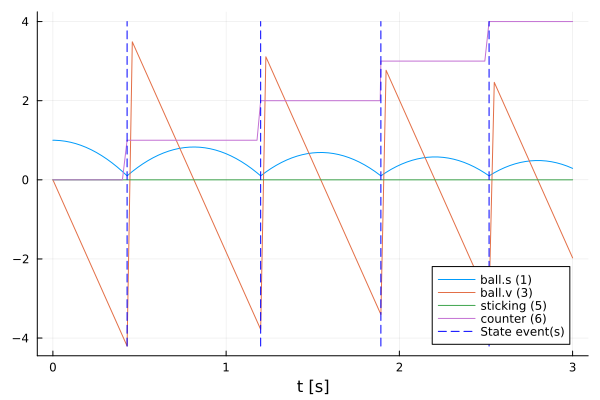

In [10]:
using FMI, DifferentialEquations
fmu.executionConfig.loggingOn = true
solution = simulate(fmu, (0.0, 3.0); recordValues=["sticking", "counter"])

using Plots
plot(solution)

## Getting started with custom project
The best way to start with your own project, is to make a *copy* of one of the example *folders*, for example the bouncing ball and edit it to fit you requirements. Because the entire package is compiled, you can control the size of the binary by adding or removing packages to the *Project.toml*. You can use *Pkg.jl* of course to manage dependencies. Then you can start overwriting the functions, that define the right-hand side of you FMU, events and event indicators and finally the output variables.